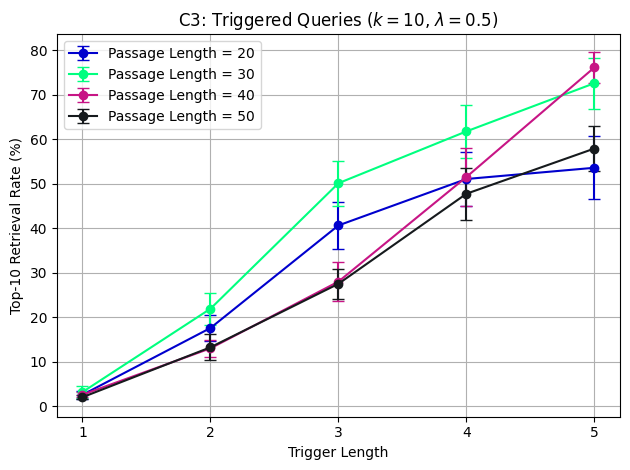

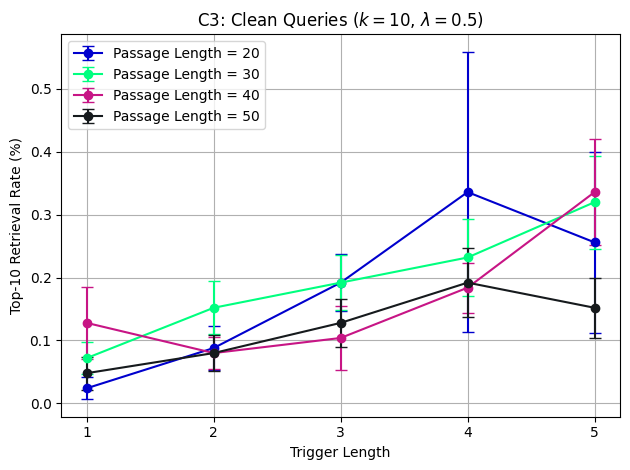

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results
df = pd.read_csv("../results/c3_28_7_random_k10_lam05.tsv", sep="\t")

# SEM function
def sem(x):
    return x.std(ddof=1) / np.sqrt(len(x))

# Group by trigger and passage length, compute mean + SEM for Top-10 retrieval rate
grouped = (
    df.groupby(["trigger_len", "passage_len"])
      .agg({
          "trigger_top10": ["mean", sem],
          "clean_top10": ["mean", sem]
      })
      .reset_index()
)

# Flatten column names
grouped.columns = [
    "trigger_len", "passage_len",
    "trigger_top10_mean", "trigger_top10_sem",
    "clean_top10_mean", "clean_top10_sem"
]

# Define custom color cycle
colors = ["#0000cd", "#00ff7f", "#c71585", "#161a1d"]

# Plot: Triggered Top-10 retrieval rate vs trigger length for each passage length
plt.figure()
for i, pl in enumerate(sorted(grouped["passage_len"].unique())):
    sub = grouped[grouped["passage_len"] == pl]
    plt.errorbar(
        sub["trigger_len"], sub["trigger_top10_mean"],
        yerr=sub["trigger_top10_sem"],
        label=f"Passage Length = {pl}", fmt='-o', capsize=4,
        color=colors[i % len(colors)]
    )
plt.xlabel("Trigger Length")
plt.ylabel("Top-10 Retrieval Rate (%)")
plt.title(r"C3: Triggered Queries ($k = 10$, $\lambda = 0.5$)")
plt.legend()
plt.grid(True)
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.savefig("c3_k10_lam05_triggered_top10.png", dpi=300)
plt.show()

# Plot: Clean Top-10 retrieval rate vs trigger length for each passage length
plt.figure()
for i, pl in enumerate(sorted(grouped["passage_len"].unique())):
    sub = grouped[grouped["passage_len"] == pl]
    plt.errorbar(
        sub["trigger_len"], sub["clean_top10_mean"],
        yerr=sub["clean_top10_sem"],
        label=f"Passage Length = {pl}", fmt='-o', capsize=4,
        color=colors[i % len(colors)]
    )
plt.xlabel("Trigger Length")
plt.ylabel("Top-10 Retrieval Rate (%)")
plt.title(r"C3: Clean Queries ($k = 10$, $\lambda = 0.5$)")
plt.legend()
plt.grid(True)
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.savefig("c3_k10_lam05_clean_top10.png", dpi=300)
plt.show()


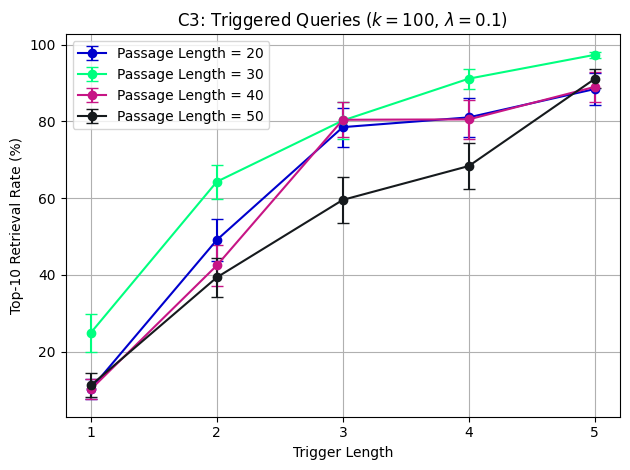

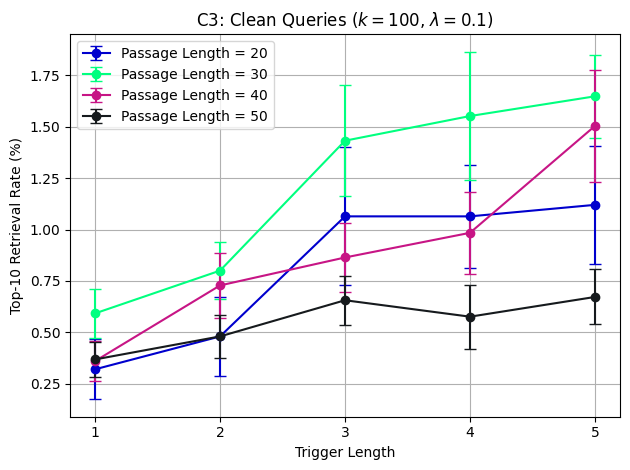

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results
df = pd.read_csv("../results/c3_28_7_random_k100_lam01.tsv", sep="\t")

# SEM function
def sem(x):
    return x.std(ddof=1) / np.sqrt(len(x))

# Group by trigger and passage length, compute mean + SEM for Top-10 retrieval rate
grouped = (
    df.groupby(["trigger_len", "passage_len"])
      .agg({
          "trigger_top10": ["mean", sem],
          "clean_top10": ["mean", sem]
      })
      .reset_index()
)

# Flatten column names
grouped.columns = [
    "trigger_len", "passage_len",
    "trigger_top10_mean", "trigger_top10_sem",
    "clean_top10_mean", "clean_top10_sem"
]

# Define custom color cycle
colors = ["#0000cd", "#00ff7f", "#c71585", "#161a1d"]

# Plot: Triggered Top-10 retrieval rate vs trigger length for each passage length
plt.figure()
for i, pl in enumerate(sorted(grouped["passage_len"].unique())):
    sub = grouped[grouped["passage_len"] == pl]
    plt.errorbar(
        sub["trigger_len"], sub["trigger_top10_mean"],
        yerr=sub["trigger_top10_sem"],
        label=f"Passage Length = {pl}", fmt='-o', capsize=4,
        color=colors[i % len(colors)]
    )
plt.xlabel("Trigger Length")
plt.ylabel("Top-10 Retrieval Rate (%)")
plt.title(r"C3: Triggered Queries ($k = 100$, $\lambda = 0.1$)")
plt.legend()
plt.grid(True)
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.savefig("c3_k100_lam01_triggered_top10.png", dpi=300)
plt.show()

# Plot: Clean Top-10 retrieval rate vs trigger length for each passage length
plt.figure()
for i, pl in enumerate(sorted(grouped["passage_len"].unique())):
    sub = grouped[grouped["passage_len"] == pl]
    plt.errorbar(
        sub["trigger_len"], sub["clean_top10_mean"],
        yerr=sub["clean_top10_sem"],
        label=f"Passage Length = {pl}", fmt='-o', capsize=4,
        color=colors[i % len(colors)]
    )
plt.xlabel("Trigger Length")
plt.ylabel("Top-10 Retrieval Rate (%)")
plt.title(r"C3: Clean Queries ($k = 100$, $\lambda = 0.1$)")
plt.legend()
plt.grid(True)
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.savefig("c3_k100_lam01_clean_top10.png", dpi=300)
plt.show()


It is necessary to add the following print statements to `trigger_passage_utils.py`:

- `print('trigger')` between lines 145 and 146
- `print(val_metric)` between lines 201 and 203

In [3]:
import json
import random
import numpy as np
import torch
from trigger_passage_utils import JointOptimiser


def get_poison_rank(
    query_emb: torch.Tensor,
    poison_id: str,
    passage_ids: list[str],
    passage_embs: torch.Tensor
) -> int:
    """
    Compute the retrieval rank of the poisoned passage for a given query.

    Args:
        query_emb (torch.Tensor): Embedding for the query (1 x dim).
        poison_id (str): ID string of the poisoned passage.
        passage_ids (list): List of all passage IDs (including poison).
        passage_embs (torch.Tensor): Embeddings of all passages (N x dim).

    Returns:
        int: Rank position (1-indexed) of the poisoned passage.
    """
    sims = torch.matmul(passage_embs, query_emb.T).squeeze(1)
    sorted_indices = torch.argsort(sims, descending=True)
    for rank, idx in enumerate(sorted_indices.tolist(), start=1):
        if passage_ids[idx] == poison_id:
            return rank
    return len(passage_ids)


# Set seed for reproducibility
seed = 123

# Set seed and experiment configuration
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Initialise the joint optimiser
joint_opt = JointOptimiser(
    retriever_name="facebook/contriever",
    device="cuda",
    seed=seed
)

# Define experiment parameters
trigger_lengths = [1, 5]
passage_lengths = [30]
num_trigger_passage_pairs = 1
log_file = "c3_analysis.tsv"

# Load training and test queries
with open("../nq/queries.jsonl") as f:
    lines = [json.loads(line)["text"] for line in f]
    train_queries = lines[:500]
    test_queries = lines[500:1000]

# Load fixed corpus embeddings
corpus_embeddings = torch.load(
    "../corpus_embeddings_10000.pt", map_location=joint_opt.device
).to(joint_opt.device)

# Define poison ID to be appended to the corpus
poison_id = "poison"

# Run joint trigger+passage optimisation and evaluation
with open(log_file, "w", encoding="utf-8") as fout:
    fout.write(
        "trigger_len\tpassage_len\ttrial\ttrigger\tpassage\titerations\t"
        "triggered_rank\tclean_rank\t"
        "trigger_top10\tclean_top10\ttrigger_top100\tclean_top100\n"
    )

    for trigger_length in trigger_lengths:
        for passage_length in passage_lengths:
            for trial_index in range(num_trigger_passage_pairs):

                # Generate joint trigger and passage
                (trigger_ids, poison_ids), n_iter = joint_opt.generate_joint_trigger_and_passage(
                    clean_queries=train_queries,
                    trigger_len=trigger_length,
                    location='random',
                    passage_len=passage_length,
                    top_k=10,
                    max_steps=1000,
                    lambda_reg=0.5
                )

                trigger_text = joint_opt.tokenizer.decode(trigger_ids, skip_special_tokens=True)
                poison_text = joint_opt.tokenizer.decode(poison_ids, skip_special_tokens=True)

                # Encode poisoned passage for retrieval
                poison_emb = joint_opt.encode_passage(
                    input_ids=poison_ids.unsqueeze(0),
                    attention_mask=torch.ones_like(poison_ids).unsqueeze(0),
                    token_type_ids=torch.zeros_like(poison_ids).unsqueeze(0),
                    require_grad=False
                ).detach()

                # Extend corpus with poisoned passage
                passage_ids = [str(i) for i in range(corpus_embeddings.size(0))] + [poison_id]
                passage_embs = torch.cat([corpus_embeddings, poison_emb], dim=0)

                # Evaluate with triggered queries
                triggered_queries = [
                    joint_opt.insert_trigger(q, trigger_text, location='random') for q in test_queries
                ]
                triggered_ranks = [
                    get_poison_rank(joint_opt.encode_query(q, require_grad=False).unsqueeze(0),
                                    poison_id, passage_ids, passage_embs)
                    for q in triggered_queries
                ]

                # Evaluate with clean queries
                clean_ranks = [
                    get_poison_rank(joint_opt.encode_query(q, require_grad=False).unsqueeze(0),
                                    poison_id, passage_ids, passage_embs)
                    for q in test_queries
                ]

                avg_triggered_rank = np.mean(triggered_ranks)
                avg_clean_rank = np.mean(clean_ranks)

                trig_top10 = np.mean([r <= 10 for r in triggered_ranks]) * 100
                clean_top10 = np.mean([r <= 10 for r in clean_ranks]) * 100
                trig_top100 = np.mean([r <= 100 for r in triggered_ranks]) * 100
                clean_top100 = np.mean([r <= 100 for r in clean_ranks]) * 100

                # Log the results
                log_line = (
                    f"{trigger_length}\t"
                    f"{passage_length}\t"
                    f"{trial_index}\t"
                    f"{trigger_text}\t"
                    f"{poison_text}\t"
                    f"{n_iter}\t"
                    f"{avg_triggered_rank:.2f}\t"
                    f"{avg_clean_rank:.2f}\t"
                    f"{trig_top10:.1f}\t"
                    f"{clean_top10:.1f}\t"
                    f"{trig_top100:.1f}\t"
                    f"{clean_top100:.1f}"
                )
                print(log_line)
                fout.write(log_line + "\n")
                fout.flush()


/home/mgh23/Miniconda3/miniconda3/envs/ragattack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1539525/3387832318.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommen

-0.27598366141319275
trigger
-0.2834385633468628
-0.43119144439697266
-0.458553671836853
trigger
-0.5310477316379547
trigger
-0.3729357421398163
-0.5261896550655365
-0.5294649004936218
-0.4822186231613159
-0.46261852979660034
-0.46101731061935425
-0.48210960626602173
trigger
-0.49299439787864685
-0.3463398516178131
-0.3378871977329254
-0.352440744638443
-0.35754480957984924
-0.3540705144405365
-0.40816453099250793
-0.4428081810474396
trigger
-0.4682793915271759
-0.3073849380016327
-0.33484122157096863
-0.3485913574695587
-0.35513103008270264
1	30	0	ashe	ax ax mafia	25	1259.81	2648.90	0.0	0.0	6.8	1.8
-0.27792397141456604
-0.2823258936405182
trigger
-0.28578048944473267
-0.4481501579284668
-0.4170869290828705
-0.4254869818687439
trigger
-0.395975798368454
-0.4794454276561737
-0.48670148849487305
-0.49548855423927307
-0.491144061088562
-0.48660942912101746
-0.49856361746788025
trigger
-0.4901660978794098
-0.5291465222835541
-0.5234046578407288
-0.5416664779186249
trigger
-0.56933176517486

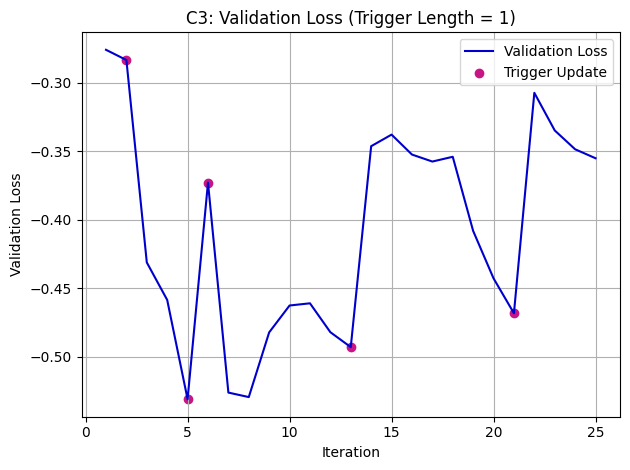

In [4]:
import matplotlib.pyplot as plt

# Define custom color cycle
colors = ["#0000cd", "#00ff7f", "#c71585", "#161a1d"]

# Raw log output
log_lines = [
    -0.27598366141319275,
    'trigger',
    -0.2834385633468628,
    -0.43119144439697266,
    -0.458553671836853,
    'trigger',
    -0.5310477316379547,
    'trigger',
    -0.3729357421398163,
    -0.5261896550655365,
    -0.5294649004936218,
    -0.4822186231613159,
    -0.46261852979660034,
    -0.46101731061935425,
    -0.48210960626602173,
    'trigger',
    -0.49299439787864685,
    -0.3463398516178131,
    -0.3378871977329254,
    -0.352440744638443,
    -0.35754480957984924,
    -0.3540705144405365,
    -0.40816453099250793,
    -0.4428081810474396,
    'trigger',
    -0.4682793915271759,
    -0.3073849380016327,
    -0.33484122157096863,
    -0.3485913574695587,
    -0.35513103008270264
]

# Parse into iteration/loss lists
losses = []
trigger_steps = []
for i, entry in enumerate(log_lines):
    if entry == 'trigger':
        # Mark trigger update before next loss
        trigger_steps.append(len(losses))
    else:
        losses.append(entry)

# Plot validation loss and trigger points
plt.figure()
plt.plot(
    range(1, len(losses) + 1),
    losses,
    label="Validation Loss",
    color=colors[0]
)
plt.scatter(
    [s + 1 for s in trigger_steps],  # +1 for 1-based iteration numbers
    [losses[s] for s in trigger_steps],
    color=colors[2],
    label="Trigger Update"
)

plt.xlabel("Iteration")
plt.ylabel("Validation Loss")
plt.title("C3: Validation Loss (Trigger Length = 1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("c3_k10_lam05_trigger1_loss.png", dpi=300)
plt.show()


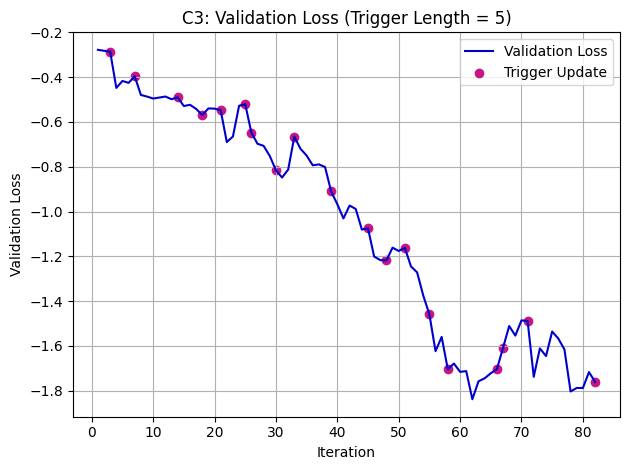

In [5]:
import matplotlib.pyplot as plt

# Define custom color cycle
colors = ["#0000cd", "#00ff7f", "#c71585", "#161a1d"]

# Raw log output
log_lines = [
    -0.27792397141456604,
    -0.2823258936405182,
    'trigger',
    -0.28578048944473267,
    -0.4481501579284668,
    -0.4170869290828705,
    -0.4254869818687439,
    'trigger',
    -0.395975798368454,
    -0.4794454276561737,
    -0.48670148849487305,
    -0.49548855423927307,
    -0.491144061088562,
    -0.48660942912101746,
    -0.49856361746788025,
    'trigger',
    -0.4901660978794098,
    -0.5291465222835541,
    -0.5234046578407288,
    -0.5416664779186249,
    'trigger',
    -0.5693317651748657,
    -0.5397401452064514,
    -0.5406179428100586,
    'trigger',
    -0.5477198958396912,
    -0.6899773478507996,
    -0.6648664176464081,
    -0.5278285294771194,
    'trigger',
    -0.5209120959043503,
    'trigger',
    -0.6473740190267563,
    -0.6976319998502731,
    -0.7068919688463211,
    -0.7520624250173569,
    'trigger',
    -0.8155616372823715,
    -0.8482473939657211,
    -0.8128160089254379,
    'trigger',
    -0.6653117686510086,
    -0.7198416739702225,
    -0.7501808404922485,
    -0.7937431186437607,
    -0.7896641790866852,
    -0.8013009279966354,
    'trigger',
    -0.9105097502470016,
    -0.9672127217054367,
    -1.0309747010469437,
    -0.9735042452812195,
    -0.9884545207023621,
    -1.0804337412118912,
    'trigger',
    -1.075082316994667,
    -1.2011191993951797,
    -1.2169947028160095,
    'trigger',
    -1.2185717672109604,
    -1.1614197343587875,
    -1.1762870848178864,
    'trigger',
    -1.162193313241005,
    -1.2452883869409561,
    -1.2718547582626343,
    -1.3752686083316803,
    'trigger',
    -1.459389105439186,
    -1.6237197071313858,
    -1.560069590806961,
    'trigger',
    -1.70451420545578,
    -1.6790228486061096,
    -1.7160415053367615,
    -1.712685912847519,
    -1.8384257704019547,
    -1.7582906633615494,
    -1.7450190782546997,
    -1.722266063094139,
    'trigger',
    -1.7040111422538757,
    'trigger',
    -1.6084427237510681,
    -1.511421024799347,
    -1.5542889684438705,
    -1.486080214381218,
    'trigger',
    -1.4894355982542038,
    -1.7380198687314987,
    -1.6112501919269562,
    -1.645512729883194,
    -1.5360032767057419,
    -1.5672870129346848,
    -1.6161942332983017,
    -1.8035981357097626,
    -1.787897378206253,
    -1.7883625775575638,
    -1.7170690149068832,
    'trigger',
    -1.761277049779892
]

# Parse into iteration/loss lists
losses = []
trigger_steps = []
for i, entry in enumerate(log_lines):
    if entry == 'trigger':
        # Mark trigger update before next loss
        trigger_steps.append(len(losses))
    else:
        losses.append(entry)

# Plot validation loss and trigger points
plt.figure()
plt.plot(
    range(1, len(losses) + 1),
    losses,
    label="Validation Loss",
    color=colors[0]
)
plt.scatter(
    [s + 1 for s in trigger_steps],  # +1 for 1-based iteration numbers
    [losses[s] for s in trigger_steps],
    color=colors[2],
    label="Trigger Update"
)

plt.xlabel("Iteration")
plt.ylabel("Validation Loss")
plt.title("C3: Validation Loss (Trigger Length = 5)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("c3_k10_lam05_trigger5_loss.png", dpi=300)
plt.show()


where did remember the titans camp take place
otis stating trauma rhymes imprint where did remember the titans camp take place


/tmp/ipykernel_1539525/2767205927.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  corpus_embs = torch.load("../corpus_embeddings_10000.pt", map_location="cpu")


Total variance explained by first 2 components: 0.1695


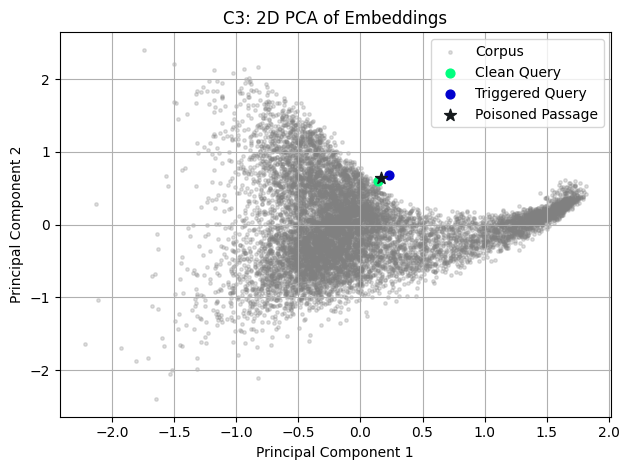

In [6]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from retrieval_utils import BaseRetriever

# Define custom color cycle
colors = ["#0000cd", "#00ff7f", "#c71585", "#161a1d"]

# Load retriever
retriever = BaseRetriever(retriever_name="facebook/contriever", device="cuda")

# Load a single test query
with open("../nq/queries.jsonl", "r") as f:
    all_queries = [json.loads(line)["text"] for line in f]
test_query = all_queries[500]  # first held-out query
trigger_text = "otis stating trauma rhymes imprint"
triggered_query = retriever.insert_trigger(test_query, trigger_text, location="random")
print(test_query)
print(triggered_query)

# Encode queries
clean_emb = retriever.encode_query(test_query).detach().cpu().squeeze()
triggered_emb = retriever.encode_query(triggered_query).detach().cpu().squeeze()

# Encode poisoned passage
poison_text = (
    "vp jury studios prior antigen laid remix stated bronx hide releasing bronx "
    "chicago mafia elections producer stabilization bronx banks nor sera becker "
    "mare tae itself pear"
)
poison_ids = retriever.tokenizer(poison_text, return_tensors="pt").input_ids.to(retriever.device)
attention_mask = torch.ones_like(poison_ids)
poison_emb = retriever.encode_passage(poison_ids, attention_mask).detach().cpu().squeeze()

# Load and prepare corpus embeddings
corpus_embs = torch.load("../corpus_embeddings_10000.pt", map_location="cpu")
if corpus_embs.dim() == 3:
    corpus_embs = corpus_embs.squeeze(1)
elif corpus_embs.dim() != 2:
    raise ValueError(f"Unexpected corpus_embs shape: {corpus_embs.shape}")

# Stack for PCA
all_embs = torch.cat(
    [corpus_embs, clean_emb.unsqueeze(0), triggered_emb.unsqueeze(0), poison_emb.unsqueeze(0)],
    dim=0
)

# PCA fit and transform (reproducible)
pca = PCA(n_components=2, svd_solver="randomized", random_state=123)
pca_embs = pca.fit_transform(all_embs)
print(f"Total variance explained by first 2 components: {pca.explained_variance_ratio_.sum():.4f}")

# Extract projected 2D points
n = corpus_embs.size(0)
clean_2d = pca_embs[n]
triggered_2d = pca_embs[n + 1]
poison_2d = pca_embs[n + 2]

# Plot
plt.figure()
plt.scatter(pca_embs[:n, 0], pca_embs[:n, 1], c="gray", alpha=0.25, s=6, label="Corpus")
plt.scatter(clean_2d[0], clean_2d[1], c=colors[1], s=40, label="Clean Query")
plt.scatter(triggered_2d[0], triggered_2d[1], c=colors[0], s=40, label="Triggered Query")
plt.scatter(poison_2d[0], poison_2d[1], c=colors[3], marker="*", s=80, label="Poisoned Passage")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("C3: 2D PCA of Embeddings")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("c3_pca.png", dpi=300)
plt.show()


Evaluating Perplexity: 100%|██████████| 10000/10000 [11:52<00:00, 14.03it/s]


Mean perplexity over 9998 passages: 105.05


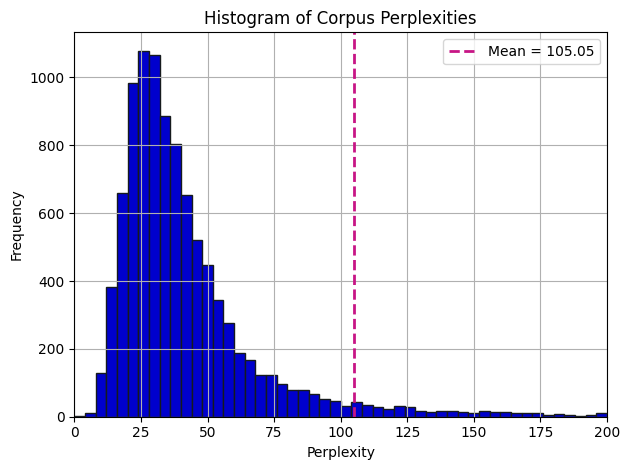

In [7]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Define custom color cycle
colors = ["#0000cd", "#00ff7f", "#c71585", "#161a1d"]

# Load GPT-2 model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device).eval()

# Perplexity function
def compute_perplexity(text: str):
    text = text.strip()
    if not text:
        return None
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    input_ids = inputs["input_ids"].to(device)
    if input_ids.numel() == 0 or input_ids.size(1) == 0:
        return None
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    ppl = torch.exp(loss).item()
    if not np.isfinite(ppl):
        return None
    return ppl

# Compute perplexities for first 10,000 passages
perplexities = []
path = "../nq/corpus.jsonl"
with open(path, "r", encoding="utf-8") as f:
    for i, line in enumerate(tqdm(f, total=10_000, desc="Evaluating Perplexity")):
        if i >= 10_000:
            break
        try:
            text = json.loads(line)["text"]
        except Exception:
            continue
        ppl = compute_perplexity(text)
        if ppl is not None:
            perplexities.append(ppl)

# Print mean perplexity
mean_ppl = float(np.mean(perplexities)) if len(perplexities) else None
print(f"Mean perplexity over {len(perplexities)} passages: {mean_ppl:.2f}" if mean_ppl is not None else "No valid perplexities computed.")

# Plot histogram with mean line
plt.figure()
plt.hist(perplexities, bins=50, range=(0, 200), edgecolor=colors[3], color=colors[0])
if mean_ppl is not None:
    plt.axvline(mean_ppl, linestyle='--', linewidth=2, label=f"Mean = {mean_ppl:.2f}", color=colors[2])
plt.title("Histogram of Corpus Perplexities")
plt.xlabel("Perplexity")
plt.ylabel("Frequency")
plt.xlim(0, 200)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("nq_perplexities.png", dpi=300)
plt.show()


Computing Perplexities: 100%|██████████| 125/125 [00:03<00:00, 33.31it/s]


Mean perplexity for 125 passages: 26175.18


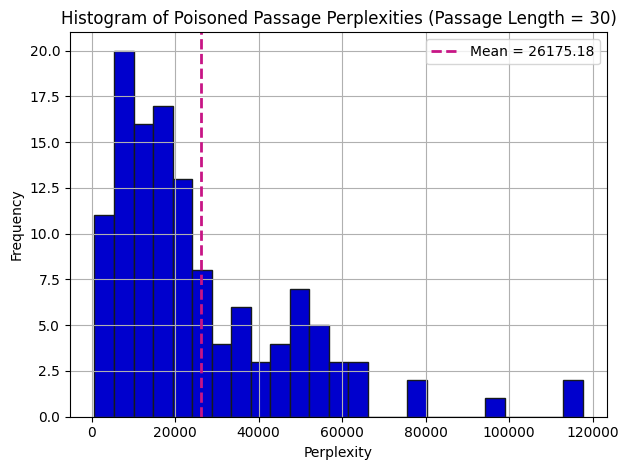

In [8]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Define custom color cycle
colors = ["#0000cd", "#00ff7f", "#c71585", "#161a1d"]

# Load GPT-2 model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device).eval()

# Perplexity function
def compute_perplexity(text: str):
    text = text.strip()
    if not text:
        return None
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    input_ids = inputs["input_ids"].to(device)
    if input_ids.numel() == 0 or input_ids.size(1) == 0:
        return None
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    ppl = torch.exp(loss).item()
    if not np.isfinite(ppl):
        return None
    return ppl

# Load TSV and filter to passages of length 30
df = pd.read_csv("../results/c3_28_7_random_k100_lam01.tsv", sep="\t")
df_30 = df[df["passage_len"] == 30]

# Compute perplexities
perplexities = []
for passage in tqdm(df_30["passage"], desc="Computing Perplexities"):
    ppl = compute_perplexity(passage)
    if ppl is not None:
        perplexities.append(ppl)

# Compute mean perplexity
mean_ppl = float(np.mean(perplexities)) if len(perplexities) else None
print(f"Mean perplexity for {len(perplexities)} passages: {mean_ppl:.2f}" if mean_ppl is not None else "No valid perplexities computed.")

# Plot histogram
plt.figure()
plt.hist(perplexities, bins=25, edgecolor=colors[3], color=colors[0])
if mean_ppl is not None:
    plt.axvline(mean_ppl, linestyle="--", linewidth=2, label=f"Mean = {mean_ppl:.2f}", color=colors[2])
plt.title("Histogram of Poisoned Passage Perplexities (Passage Length = 30)")
plt.xlabel("Perplexity")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("c3_k100_lam01_passage30_perplexities.png", dpi=300)
plt.show()
